# DuraMAT Workshop Live Demo - Geospatial analysis

![PVDeg Logo](../PVD_logo.png)

***
2023.09.26
***

**Steps:**
1. Initialize weather data into xarray
2. Calculate installation standoff for New Mexico
3. Plot results

**Xarray: multi-dimensional data frame**

![Xarray](./images/xarray.webp)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
import dask.array as da
import dask.dataframe as dd
import xarray as xr

## 1 Start distributed compute cluster - DASK

In [3]:
pvdeg.geospatial.start_dask()

Dashboard: http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 188.32 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37878,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 188.32 GiB
Comm: tcp://127.0.0.1:39626,Total threads: 6
Dashboard: http://127.0.0.1:41846/status,Memory: 23.54 GiB
Nanny: tcp://127.0.0.1:42499,


In [4]:
# Get weather data
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

In [5]:
weather_ds

<xarray.Dataset>
Dimensions:            (time: 17520, gid: 2018267)
Coordinates:
  * gid                (gid) int64 0 1 2 3 4 ... 2018263 2018264 2018265 2018266
  * time               (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:30:00
Data variables:
    temp_air           (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
    wind_speed         (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
    dhi                (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
    ghi                (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
    dni                (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
    relative_humidity  (time, gid) float32 dask.array<chunksize=(17520, 500), meta=np.ndarray>
Attributes:
    full_version_record:  {"rex": "0.2.80", "pandas": "2.0.0", "numpy": "1.23...
    package:              rex
    version:              4.0.0

In [6]:
meta_df['state'].unique()

array([nan, 'Northern', 'Eastern', 'Alaska', 'Alo', 'Singave', 'Midway',
       'Uvéa', "Vava'u", "Ha'apai", 'Niuas', 'Vaisigano', "Satupa'itea",
       'Gagaifomauga', 'Palauli', "Gaga'emauga", "Fa'asaleleaga",
       'Aiga-i-le-Tai', "A'ana", 'Tuamasaga', 'Atua', "Va'a-o-Fonoti",
       'Western', "Manu'a", 'Palmyra', 'Hawaii', 'Îles Sous-le-Vent',
       'Îles du Vent', 'Îles Tuamotu-Gambier', 'Îles Marquises',
       'British Columbia', 'Washington', 'Oregon', 'California',
       'Alberta', 'Nevada', 'Baja California', 'Idaho', 'Montana',
       'Baja California Sur', 'Sonora', 'Arizona', 'Utah', 'Wyoming',
       'Saskatchewan', 'Sinaloa', 'Colorado', 'New Mexico', 'Chihuahua',
       'Durango', 'Texas', 'Nayarit', 'Jalisco', 'Colima', 'Zacatecas',
       'North Dakota', 'South Dakota', 'Nebraska', 'Coahuila',
       'Michoacán', 'Oklahoma', 'Aguascalientes', 'San Luis Potosí',
       'Guerrero', 'Guanajuato', 'Kansas', 'Manitoba', 'Nuevo León',
       'Querétaro', 'México', 'Tam

In [7]:
meta_NM = meta_df[meta_df['state'] == 'New Mexico']

In [8]:
meta_NM_sub, gids_NM_sub = pvdeg.utilities.gid_downsampling(meta_NM, 4)
weather_NM_sub = weather_ds.sel(gid=meta_NM_sub.index)

In [9]:
geo = {'func': pvdeg.standards.standoff,
       'weather_ds': weather_NM_sub,
       'meta_df': meta_NM_sub}

standoff_res = pvdeg.geospatial.analysis(**geo)

In [10]:
standoff_res

<xarray.Dataset>
Dimensions:    (latitude: 18, longitude: 19)
Coordinates:
  * latitude   (latitude) float32 31.37 31.69 32.01 32.33 ... 36.17 36.49 36.81
  * longitude  (longitude) float32 -109.0 -108.7 -108.4 ... -103.9 -103.6 -103.3
Data variables:
    x          (latitude, longitude) float64 3.665 3.872 4.039 ... 3.403 3.744
    T98_inf    (latitude, longitude) float64 54.15 54.4 54.89 ... 53.41 54.45
    T98_0      (latitude, longitude) float64 83.05 83.83 84.19 ... 82.39 83.18
Attributes:
    x:        {'units': 'cm'}
    T98_0:    {'units': 'Celsius'}
    T98_inf:  {'units': 'Celsius'}

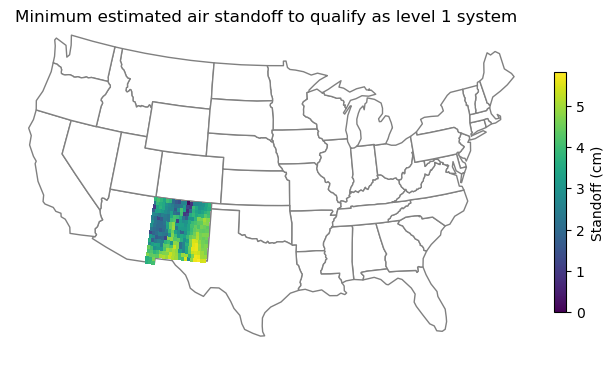

In [11]:
fig, ax = pvdeg.geospatial.plot_USA(standoff_res['x'], 
                   cmap='viridis', vmin=0, vmax=None, 
                   title='Minimum estimated air standoff to qualify as level 1 system', 
                   cb_title='Standoff (cm)')

# Relative Humidity Example - Time dimension

In [12]:
# State bar of new mexico: (35.16482, -106.58979)

weather_db = 'NSRDB'
weather_id = (35.16482, -106.58979) #NREL (39.741931, -105.169891)
weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_df, meta = pvdeg.weather.get(weather_db, weather_id, geospatial=False, **weather_arg)

In [13]:
RH_module = pvdeg.humidity.module(weather_df=weather_df, meta=meta)

In [14]:
RH_module

,RH_surface_outside,RH_front_encap,RH_back_encap,RH_backsheet
2022-01-01 00:00:00+00:00,71.649999,31.528307,71.649999,71.649999
2022-01-01 00:30:00+00:00,74.709997,32.024485,72.822033,73.766015
2022-01-01 01:00:00+00:00,80.609993,32.616025,74.309248,77.459620
2022-01-01 01:30:00+00:00,81.749990,32.787592,74.853744,78.301867
2022-01-01 02:00:00+00:00,86.209989,32.960311,75.484062,80.847025
...,...,...,...,...
2022-12-31 21:30:00+00:00,21.911850,20.388574,29.615410,25.763630
2022-12-31 22:00:00+00:00,33.679013,23.695321,34.384727,34.031870
2022-12-31 22:30:00+00:00,40.611295,25.415238,37.026168,38.818731
2022-12-31 23:00:00+00:00,49.795689,27.291544,40.092491,44.944090


<Axes: >

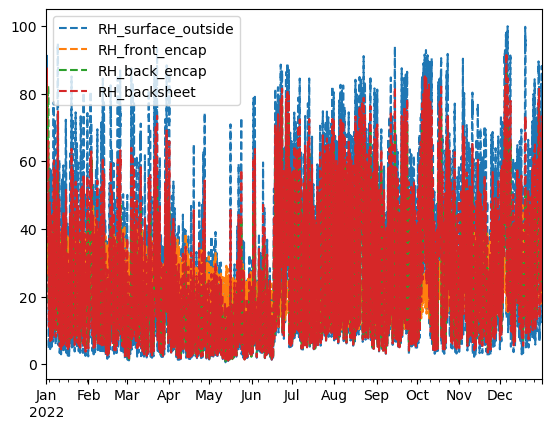

In [15]:
RH_module.plot(ls='--')

In [16]:
geo = {'func': pvdeg.humidity.module,
       'weather_ds': weather_NM_sub,
       'meta_df': meta_NM_sub}

RH_module = pvdeg.geospatial.analysis(**geo)

In [17]:
RH_module

<xarray.Dataset>
Dimensions:             (latitude: 18, longitude: 19, time: 17520)
Coordinates:
  * latitude            (latitude) float32 31.37 31.69 32.01 ... 36.49 36.81
  * longitude           (longitude) float32 -109.0 -108.7 ... -103.6 -103.3
  * time                (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:30:00
Data variables:
    RH_surface_outside  (time, latitude, longitude) float64 77.43 ... 31.64
    RH_front_encap      (time, latitude, longitude) float64 33.46 ... 27.26
    RH_back_encap       (time, latitude, longitude) float64 77.43 ... 19.44
    RH_backsheet        (time, latitude, longitude) float64 77.43 ... 25.54

In [18]:
# from matplotlib.animation import FuncAnimation
# from matplotlib.animation import PillowWriter
# import matplotlib.animation as animation
# import datetime
# ims = []
# for n in range(1, 13):
#     for i, np_t in enumerate(RH_module.time):
#         t = pd.Timestamp(np_t.values).time()
#         d = pd.Timestamp(np_t.values).day
#         m = pd.Timestamp(np_t.values).month
#         if m == n:
#             if d == 15:
#                 if t == datetime.time(12):
#                     fig, ax = pvdeg.geospatial.plot_USA(RH_module['RH_surface_outside'].sel(time=np_t),
#                             cmap='viridis', vmin=0, vmax=100, 
#                             title=f'RH_surface_outside  - 2022-{m}-{d} 12:00', 
#                             cb_title='Relative humidity (%)')
#                     plt.savefig(f'./images/RH_animation_{n}.png', dpi=600)

# import imageio
# ims = [imageio.imread(f'./images/RH_animation_{n}.png') for n in range(1, 13)]
# imageio.mimwrite(f'./images/RH_animation.gif', ims, format='GIF', duration=1000, loop=10)

![PVDeg Logo](./images/RH_animation.gif)